# Viviendas en California
**Xander Gallegos Velica | 737989**

La variable objetivo es el valor medio de la vivienda en los condados de California, expresado en cientos de miles de dólares ($100,000).

Este conjunto de datos se derivó del censo estadounidense de 1990, utilizando una fila por grupo de bloques del censo. Un grupo de bloques es la unidad geográfica más pequeña para la cual la Oficina del Censo de EE. UU. publica datos de muestra (un grupo de bloques suele tener una población de 600 a 3000 personas).

Un hogar es un grupo de personas que residen dentro de una casa. Dado que el número promedio de habitaciones y dormitorios en este conjunto de datos se proporciona por hogar, estas columnas pueden tomar valores sorprendentemente grandes para grupos de bloques con pocos hogares y muchas casas vacías, como los centros turísticos.

- `MedInc`: ingreso medio en el grupo de bloques
- `HouseAge`: edad media de la vivienda en el grupo de bloques
- `AveRooms`: número medio de habitaciones por hogar
- `AveBedrms`: número medio de habitaciones por hogar
- `Población`: población del grupo de bloques
- `AveOccup`: número medio de miembros del hogar
- `Latitude`: latitud del grupo de bloques
- `Longitude`: longitud del grupo de bloques

https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
import geopandas
import matplotlib.pyplot as plt

## Lectura de datos

In [2]:
df = fetch_california_housing(as_frame=True).frame
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [3]:
df.shape

(20640, 9)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


Se pueden observar valores demasiado altos para lo que uno pensaría lógico en variables como `AveRooms`, `AbeBedrms` y `AveOccup`. Esto se puede explicar por los hoteles o resorts vacacionales que registran un gran número de habitaciones.

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
MedInc,20640.0,3.870671,1.899822,0.499900,2.563400,3.534800,4.743250,15.000100
HouseAge,20640.0,28.639486,12.585558,1.000000,18.000000,29.000000,37.000000,52.000000
AveRooms,20640.0,5.429000,2.474173,0.846154,4.440716,5.229129,6.052381,141.909091
AveBedrms,20640.0,1.096675,0.473911,0.333333,1.006079,1.048780,1.099526,34.066667
Population,20640.0,1425.476744,1132.462122,3.000000,787.000000,1166.000000,1725.000000,35682.000000
AveOccup,20640.0,3.070655,10.386050,0.692308,2.429741,2.818116,3.282261,1243.333333
Latitude,20640.0,35.631861,2.135952,32.540000,33.930000,34.260000,37.710000,41.950000
Longitude,20640.0,-119.569704,2.003532,-124.350000,-121.800000,-118.490000,-118.010000,-114.310000
MedHouseVal,20640.0,2.068558,1.153956,0.149990,1.196000,1.797000,2.647250,5.000010


## Distribuciones y asimetría
Ninguna de las columnas muestra distribuciones perfectamente Gaussianas, sin embargo, las más llamativas en cuanto a su extrema asimetría son:
- `AveRooms`
- `AveBedrms`
- `Population`
- `AveOccup`

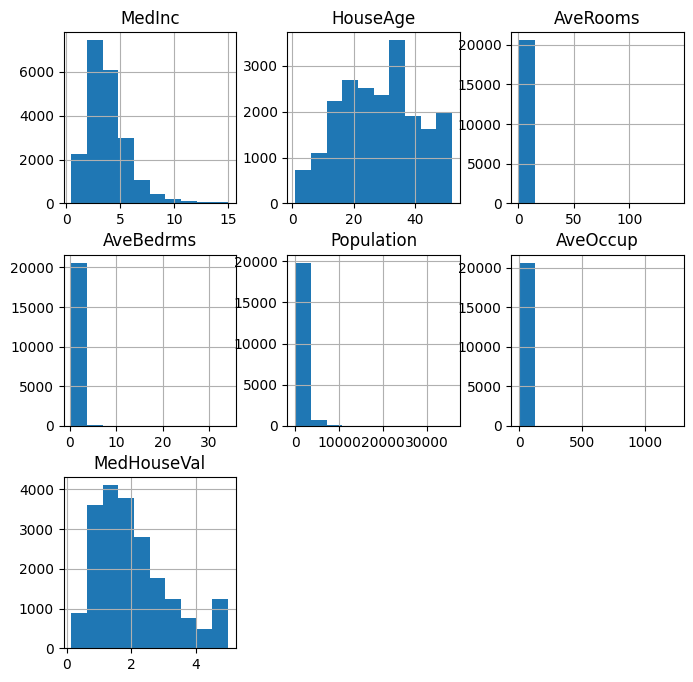

In [6]:
df.drop(columns=['Latitude', 'Longitude']).hist(figsize=(8,8))
plt.show()

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

skewness = {}
for col in scaled_df.columns:
  skewness[col] = scaled_df[col].skew()
  # print(f'{col} >> skew: {round(df[col].skew(), 2)}')

skewness = pd.DataFrame.from_dict(skewness, orient='index', columns=['skew'])
skewness.sort_values(by=['skew'], key=abs, inplace=True)
skewness

,skew
HouseAge,0.060331
Longitude,-0.297801
Latitude,0.465953
MedHouseVal,0.977763
MedInc,1.646657
Population,4.935858
AveRooms,20.697869
AveBedrms,31.316956
AveOccup,97.639561


## Datos atípicos
Observamos que 6 de las 9 variables predictoras cuentan con datos atípicos, todos en una proporción menor al 7% por columna, es decir, en una razón manejable.

In [8]:
def find_boundaries(df_var, distance=1.5):
    IQR = df_var.quantile(0.75)-df_var.quantile(0.25)
    lower = df_var.quantile(0.25)-IQR*distance
    upper = df_var.quantile(0.75)+IQR*distance
    return lower,upper

outliers = pd.DataFrame(columns=['number_outliers'], index=scaled_df.columns)

scaled_df['outlier'] = np.zeros(scaled_df.shape[0])

for col in scaled_df.columns:
    lmin,lmax = find_boundaries(scaled_df[col])
    outliers.loc[col, 'number_outliers'] = len(scaled_df.loc[scaled_df[col]<lmin]) + len(scaled_df.loc[scaled_df[col] > lmax])

    if col in ['AveBedrms', 'AveRooms', 'AveOccup']:
      scaled_df.loc[scaled_df[col] < lmin, 'outlier'] = 1
      scaled_df.loc[scaled_df[col] > lmax, 'outlier'] = 1

outliers.sort_values(by='number_outliers', ascending=False, inplace=True)
outliers['%_outliers'] = outliers['number_outliers'] / scaled_df.shape[0] * 100

outliers.drop('outlier')

,number_outliers,%_outliers
AveBedrms,1424,6.899225
Population,1196,5.794574
MedHouseVal,1071,5.188953
AveOccup,711,3.444767
MedInc,681,3.299419
AveRooms,511,2.475775
HouseAge,0,0.0
Latitude,0,0.0
Longitude,0,0.0


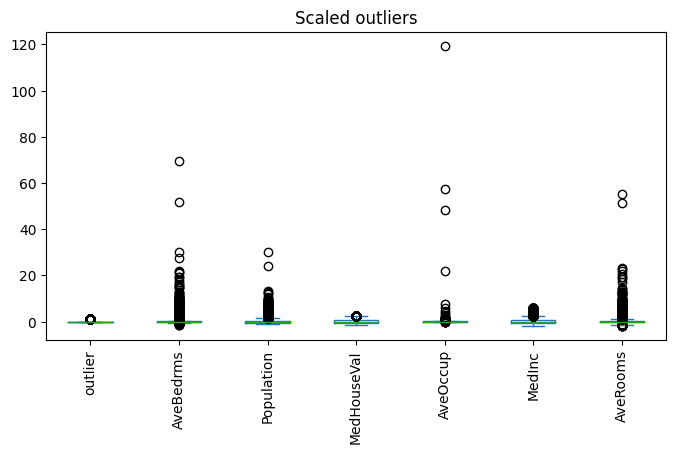

In [9]:
outlier_cols = outliers.loc[outliers['number_outliers']>0].index

fig, ax = plt.subplots(figsize=(8,4))

scaled_df[outlier_cols].plot(kind='box', ax=ax)
ax.set_xticklabels(outlier_cols, rotation=90)
ax.set_title('Scaled outliers')

plt.show()

## Valor mediano de los inmuebles por región
Se puede observar que las áreas en las que el valor mediano de los inmuebles es más alto están consentradas en la costa de San Francisco y de Los Ángeles

In [10]:
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.Longitude, df.Latitude), crs='EPSG:27561'
)

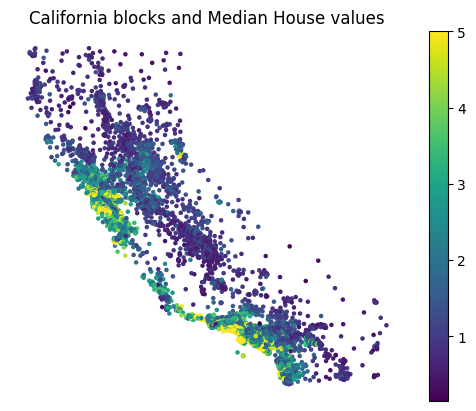

In [11]:
# Areas with higher median house values -> San Francisco (Silicon Valley) and Los Angeles

ax = gdf.plot(markersize=5,column='MedHouseVal', legend=True)
ax.set_title('California blocks and Median House values')

# gdf.loc[gdf.outlier == 1].plot(ax=ax, color='red', markersize=5, marker='*', label='outlier')
# plt.legend()

ax.set_axis_off()
plt.show()

## Contextualización
En la década de 1990, el mercado inmobiliario en San Francisco fue moldeado por un auge tecnológico  liderado por empresas como Netscape, Microsoft, Intel, entre otras, que atrajeron a profesionales del sector, generando una demanda creciente de viviendas. La escasez de oferta, debido a restricciones en el desarrollo urbano y la limitada disponibilidad de terrenos, condujo a una competencia intensa entre los compradores. Este desequilibrio entre la oferta y la demanda resultó en un aumento significativo de los precios de la vivienda, especialmente en áreas cercanas a centros tecnológicos y zonas urbanas de alta demanda. La transformación económica y cultural y la gentrificación impactaron la dinámica del mercado inmobiliario en San Francisco durante esta década.

De manera similar, Los Angeles tenía una economía diversificada que incluía entretenimiento y medios, manufactura, comercio, finanzas y tecnología. La ciudad era un importante centro para la industria del entretenimiento, con Hollywood como centro global para la producción de cine y televisión. La ciudad se consolidó como un centro cultural y económico, atrayendo a profesionales, artistas y empresarios. La diversidad de oportunidades laborales y la presencia de la industria del entretenimiento fueron factores significativos que impulsaron la demanda de viviendas en la región.

## Estimado poblacional por condados
https://www2.census.gov/programs-surveys/popest/datasets/1990-2000/counties/asrh/co-99-10.txt

In [12]:
with open('co-99-10.txt', 'r') as file:
  lines = file.readlines()
  file.close()

with open('new_co-99-10.txt', 'w') as file:
  for line in lines:
    file.writelines(','.join(line.split()) + '\n')
  file.close()

In [13]:
# (CO-99-10)  Population Estimates for Counties: Race By Hispanic Origin Annual Time Series,
#              July 1, 1990 to July 1, 1999

population = pd.read_csv('new_co-99-10.txt')
population = population.loc[population.Year == 1990]

population.FIPS_Code = population.FIPS_Code.astype(str)
population = population[population.FIPS_Code.str.startswith('6')]
population.head()

,Year,FIPS_Code,NH_White,NH_Black,NH_American_Indian,NH_Asian,H_White,H_Black,H_American_Indian,H_Asian
1840,1990,6001,677692,237175,6759,191649,165553,10756,4090,12128
1850,1990,6003,765,5,257,5,46,1,27,0
1860,1990,6005,25407,1697,460,201,2440,20,43,21
1870,1990,6007,159344,2270,2979,5082,12788,177,505,352
1880,1990,6009,29827,179,607,187,1619,8,95,17


In [14]:
population.FIPS_Code = population.FIPS_Code.astype(int)
population.FIPS_Code -= 6000

In [19]:
!unzip ca-county-boundaries.zip

Archive:  ca-county-boundaries.zip
   creating: CA_Counties/
 extracting: CA_Counties/CA_Counties_TIGER2016.cpg  
  inflating: CA_Counties/CA_Counties_TIGER2016.dbf  
  inflating: CA_Counties/CA_Counties_TIGER2016.prj  
  inflating: CA_Counties/CA_Counties_TIGER2016.sbn  
  inflating: CA_Counties/CA_Counties_TIGER2016.sbx  
  inflating: CA_Counties/CA_Counties_TIGER2016.shp  
  inflating: CA_Counties/CA_Counties_TIGER2016.shp.xml  
  inflating: CA_Counties/CA_Counties_TIGER2016.shx  


In [20]:
counties = geopandas.read_file('/content/CA_Counties/CA_Counties_TIGER2016.shp')
counties = counties[['COUNTYFP', 'NAME', 'geometry']]
counties.COUNTYFP = counties.COUNTYFP.astype(int)

In [21]:
population = pd.merge(counties, population, left_on='COUNTYFP', right_on='FIPS_Code').drop(columns=['Year', 'FIPS_Code'])

In [22]:
population['White_percentage'] = population[['NH_White', 'H_White']].sum(axis=1) / population.select_dtypes(int).drop('COUNTYFP', axis=1).sum(axis=1)

Erroneamente puede existir la hipótesis de que las áreas con mayor consentración de personas blancas serían también las que cuentan con precios inmobiliarios más altos.

Sin embargo, sucede de manera contraria, esto por que la alta tasa de inmigración a condados como San Francisco o Los Ángeles es provocada por la alta demanda de profesionistas o las mejores oportunidades de empleo, que también hacen que los costos inmobiliarios suban.

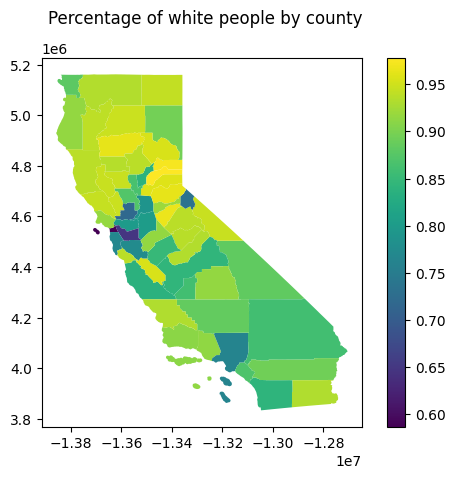

In [24]:
population.plot(column='White_percentage', legend=True)
plt.suptitle('Percentage of white people by county')
plt.show()